<a href="https://colab.research.google.com/github/gal-dmitry/HSE_CV/blob/main/homework_4_Elon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Домашнее задание № 4: Better call Elon.

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW4 <Фамилия Имя>**

soft deadline: 14.05.2021T23:59:00+0300

hard deadline: 21.05.2021T23:59:00+0300


Вы решили создать свою Self-Driving-Cars компанию.

Одной из самых главных задач в данном случае  -- это определять, что находится вокруг машины. Для этого необходимо применить методы компьютерного зрения, а именно решить задачу Object Detection. 

Измерьте качество определения объектов по датасету:

https://bdd-data.berkeley.edu/

с помощью двух алгоритмов и сравните их качество.

In [ ]:
import os
import numpy as np
import cv2 as cv2
from PIL import Image
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import random
from scipy import ndimage
import json
import sys

In [ ]:
import torch
import torchvision
import torchvision.transforms as T

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Detection Rate

In [ ]:
# your code here

---

Всё прошло довольно неплохо и Ваши старания дали плоды. 

Но для улучшения результата Вам нужно собрать данные, оборудование и набрать команду разработчиков. А для этого нужны инвестиции. 

Для привлечения внимания сторонних инвесторов, предлагается пригласить Илона на открытие Вашего первого офиса. Но из короновирусных ограничений Илон не сможет прилететь. А фотография с ним Вам очень нужна.

***3. (10 баллов)*** Помогите Илону оказаться в Северной столице. Возьмите фото из приложения к домашнему заданию и перместите миллиардера и филантропа на улицу СПБ. Сделайте это двумя способами:

* напрямую методами opencv -- без сегментации;
* с помощью сегментации двумя методами:
        - grabcut;
        - mask r-cnn(например из detectron-a)

### OpenCV

In [ ]:
elon = cv2.imread("elon_thumbs.jpeg")
# elon = cv2.cvtColor(elon, cv2.COLOR_BGR2RGB)

background = cv2.imread("street.jpg")
# background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)

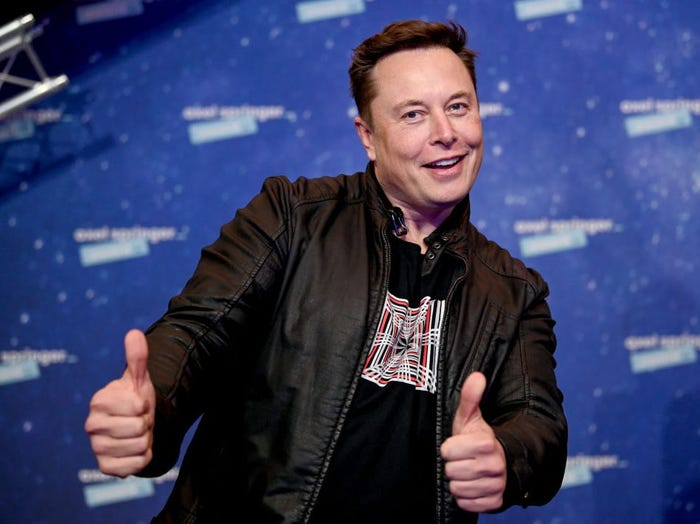

In [ ]:
cv2_imshow(elon)

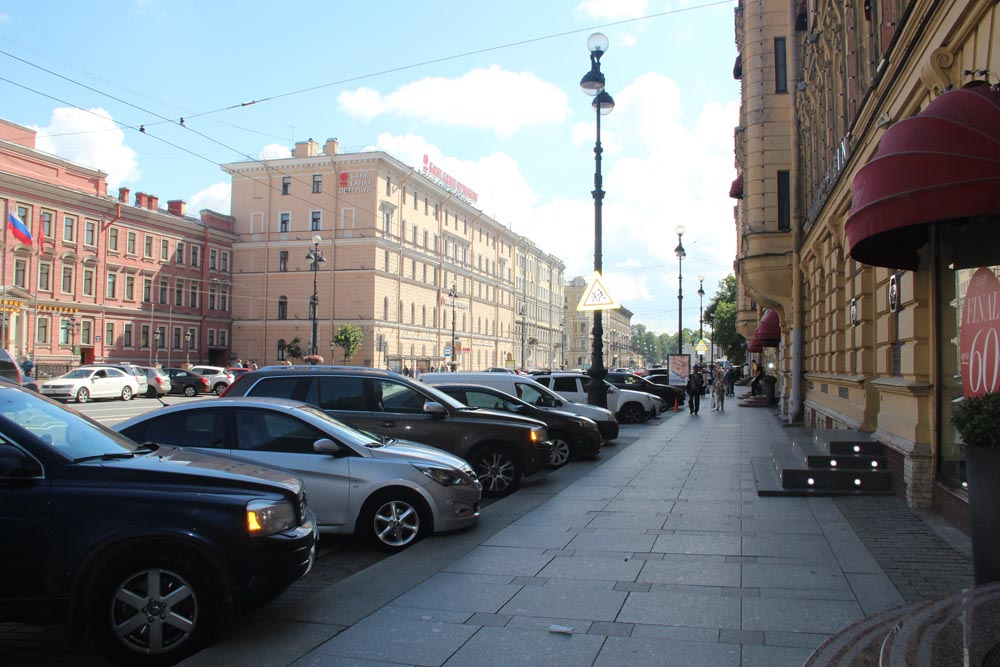

In [ ]:
cv2_imshow(background)

In [ ]:
def scale(src, scale_percent=50):
    width = int(src.shape[1] * scale_percent / 100)
    height = int(src.shape[0] * scale_percent / 100)

    dsize = (width, height)
    output = cv2.resize(np.copy(src), dsize)

    return output

In [ ]:
def get_mask(elon):
    elon_gray = cv2.cvtColor(elon, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(elon_gray, 0, 255, cv2.THRESH_BINARY)
    mask[mask!=255] = 255
    return mask

In [ ]:
def elon_in_spb(elon, spb, mask, h, w):
    img1 = np.copy(spb)
    img2 = np.copy(elon)

    rows,cols,channels = img2.shape
    roi = img1[h:rows+h, w:cols+w]

    mask_wht = np.copy(mask)
    mask_wht[mask_wht==1] = 255
    mask_inv = cv2.bitwise_not(mask_wht)

    img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask_wht)

    dst = cv2.add(img1_bg,img2_fg)
    img1[h:rows+h, w:cols+w] = dst

    return img1

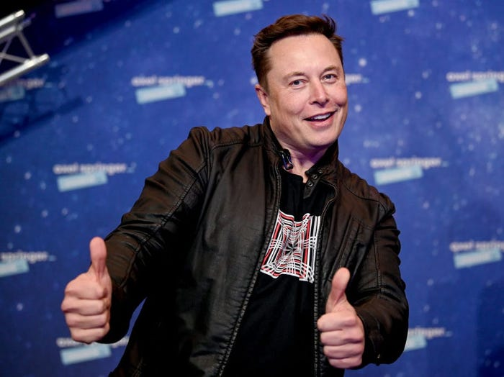

In [ ]:
scaled_elon = scale(elon, scale_percent=72)
cv2_imshow(scaled_elon)

In [ ]:
'''difference in size'''
print('h:', background.shape[0] - scaled_elon.shape[0])
print('w:', background.shape[1] - scaled_elon.shape[1])

h: 290
w: 496


### 

In [ ]:
gray_image = cv2.cvtColor(scaled_elon, cv2.COLOR_RGB2GRAY)

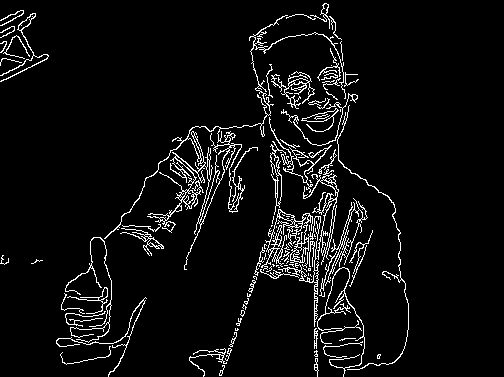

In [ ]:
edges = cv2.Canny(gray_image,10,275)
cv2_imshow(edges)

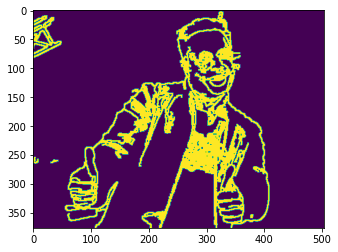

In [ ]:
kernel = np.ones((3, 3))
edges_2 = cv2.dilate(edges, kernel)
plt.imshow(edges_2)

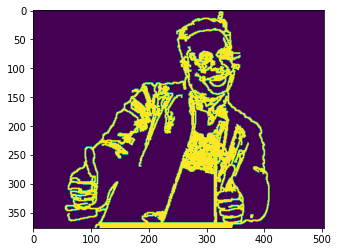

In [ ]:
edges_3 = np.copy(edges_2)
edges_3[-10:, 115:345] = 255
edges_3[:100, :100] = 0
edges_3[250:300, :50] = 0
plt.imshow(edges_3)

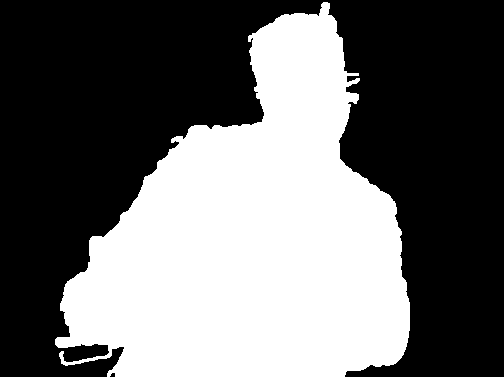

In [ ]:
edges_4 = (ndimage.binary_fill_holes(edges_3)*255).astype('uint8')
cv2_imshow(edges_4)

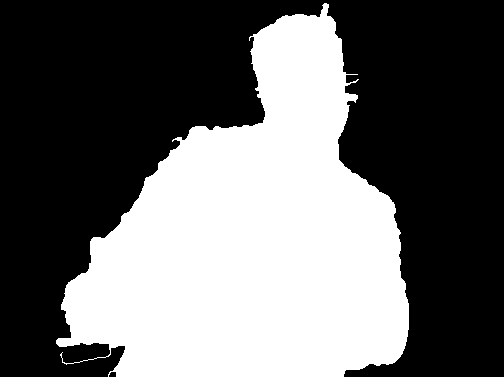

In [ ]:
kernel = np.ones((3, 3))
edges_5 = cv2.erode(edges_4, kernel)

cv2_imshow(edges_5)

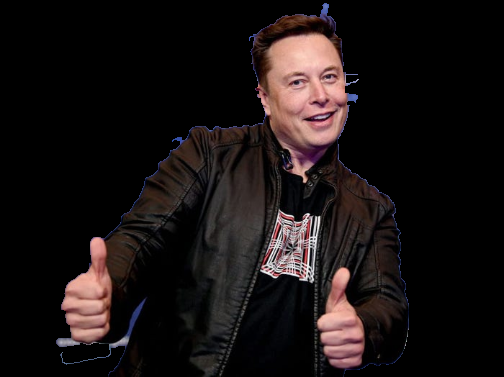

In [ ]:
mask_0 = np.copy(edges_5)
mask_0[mask_0 == 255] = 1

img_0 = scaled_elon * mask_0[:,:,np.newaxis]
cv2_imshow(img_0)

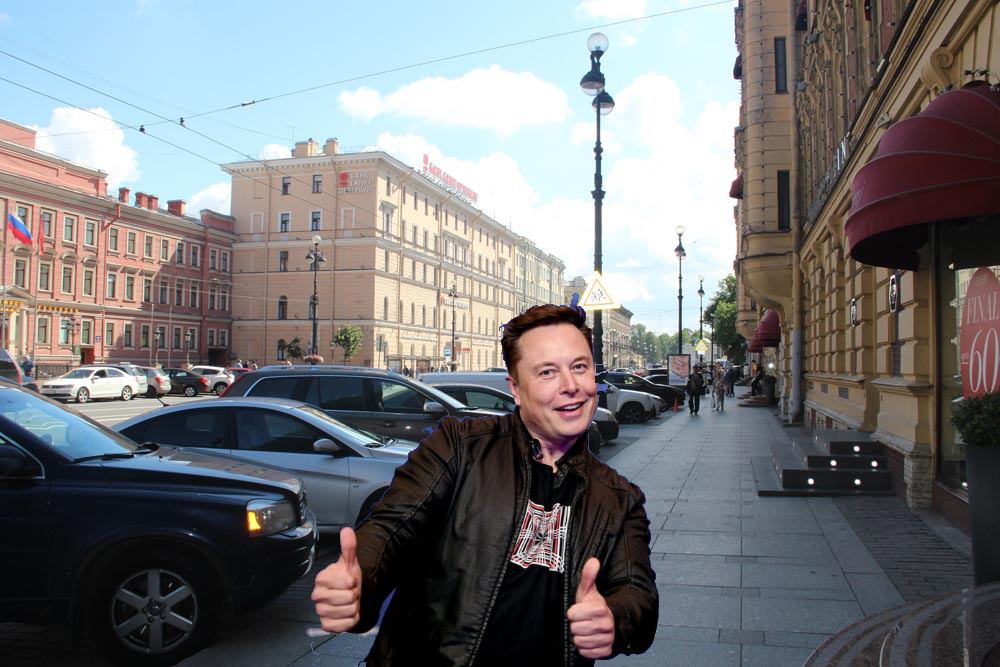

In [ ]:
final_img_0 = elon_in_spb(img_0, background, mask_0, 290, 250)
cv2_imshow(final_img_0)

---

###GrabCut

[OpenCV docs](https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html)

(377, 504, 3)

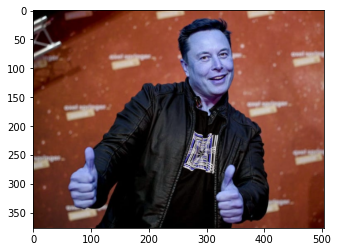

In [ ]:
plt.imshow(scaled_elon)
scaled_elon.shape

In [ ]:
mask = np.zeros(scaled_elon.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

itercount = 5
rect = (50,0,420,377)

mask, _, _ = cv2.grabCut(scaled_elon,mask,rect,bgdModel,fgdModel,itercount,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

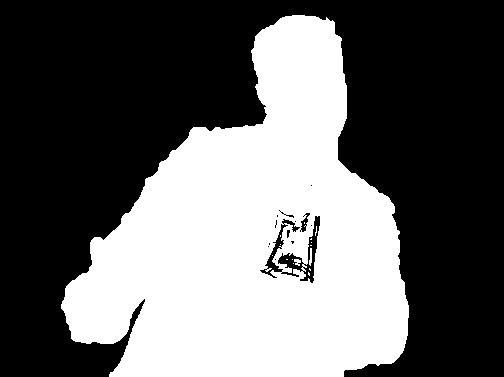

In [ ]:
clos = np.copy(mask2)
clos[clos==1] = 255
cv2_imshow(clos)

In [ ]:
clos[200:300, 250:350] = 255

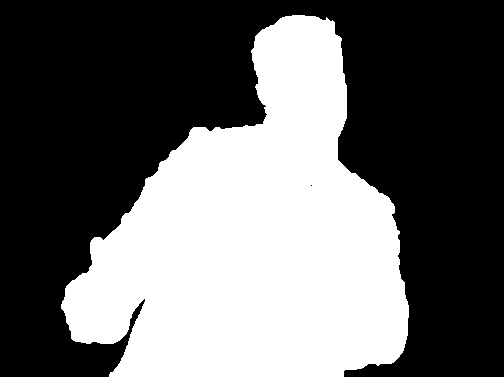

In [ ]:
cv2_imshow(clos)

In [ ]:
mask2 = np.copy(clos)
mask2[mask2==255] = 1

(377, 504, 3)

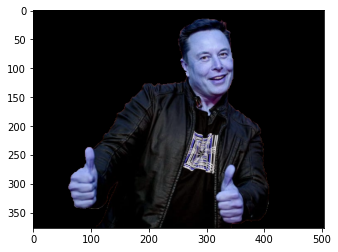

In [ ]:
img = scaled_elon * mask2[:,:,np.newaxis]

plt.imshow(img)
img.shape

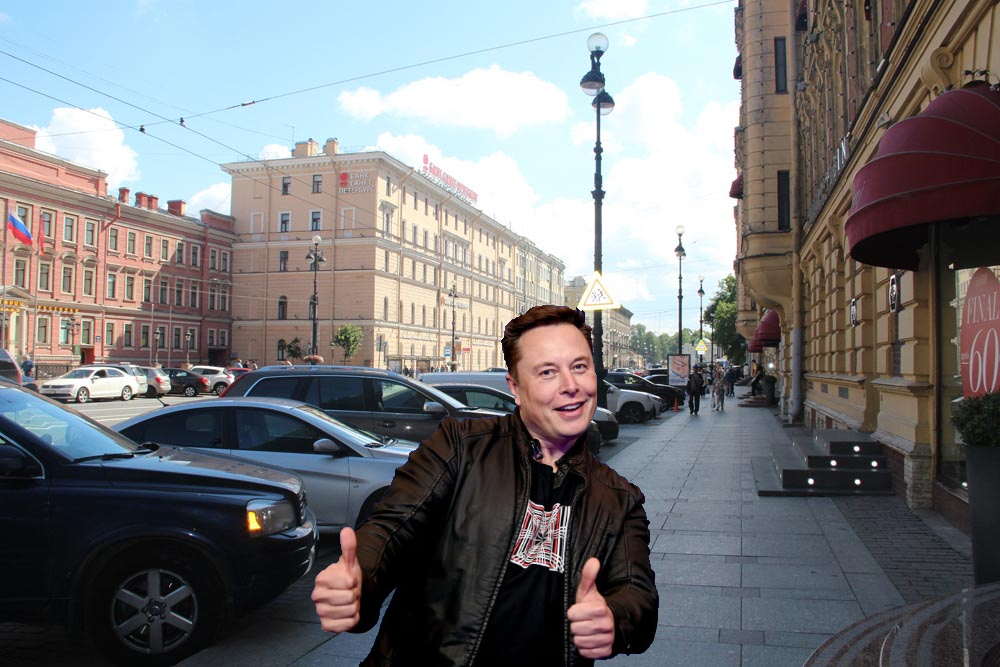

In [ ]:
final_img2 = elon_in_spb(img, background, mask2, 290, 250)
cv2_imshow(final_img2)

---

### Mask R-CNN

[Official Detectron2 tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=8IRGo8d0qkgR)

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 11.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=2395e73bd1204c6a8b3ef3363b5cb9f29a2bc6124da9c63878e6a662f77724de
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 2.3MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=de444278951307e1b3358514b21ee56cd18e9f8fee0aa03cf7c4476ab8fae1e2
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
im = scaled_elon

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:16, 11.0MB/s]                           


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0], device='cuda:0')
Boxes(tensor([[ 62.5183,  12.2771, 408.9685, 375.0034]], device='cuda:0'))


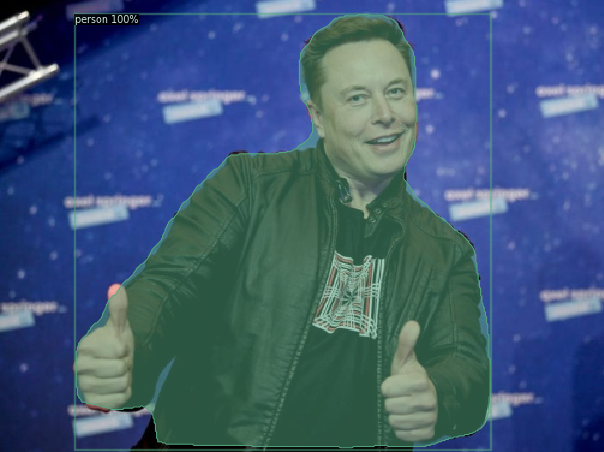

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
ab = (outputs["instances"].pred_masks.to("cpu").numpy() * 1).astype('uint8')

In [ ]:
ab.shape

(1, 377, 504)

In [ ]:
scaled_elon.shape

(377, 504, 3)

In [ ]:
mask3 = np.copy(ab.transpose(1, 2, 0))
mask3[mask3==1]=255

In [ ]:
mask3.shape

(377, 504, 1)

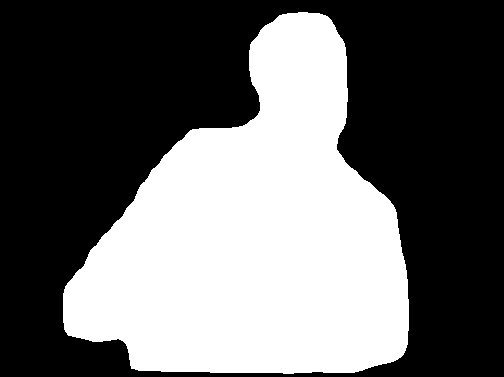

In [ ]:
cv2_imshow(mask3)

In [ ]:
mask3[mask3==255]=1

In [ ]:
img3 = scaled_elon * mask3

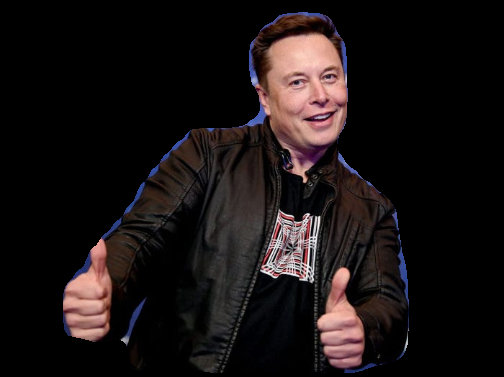

In [ ]:
cv2_imshow(img3)

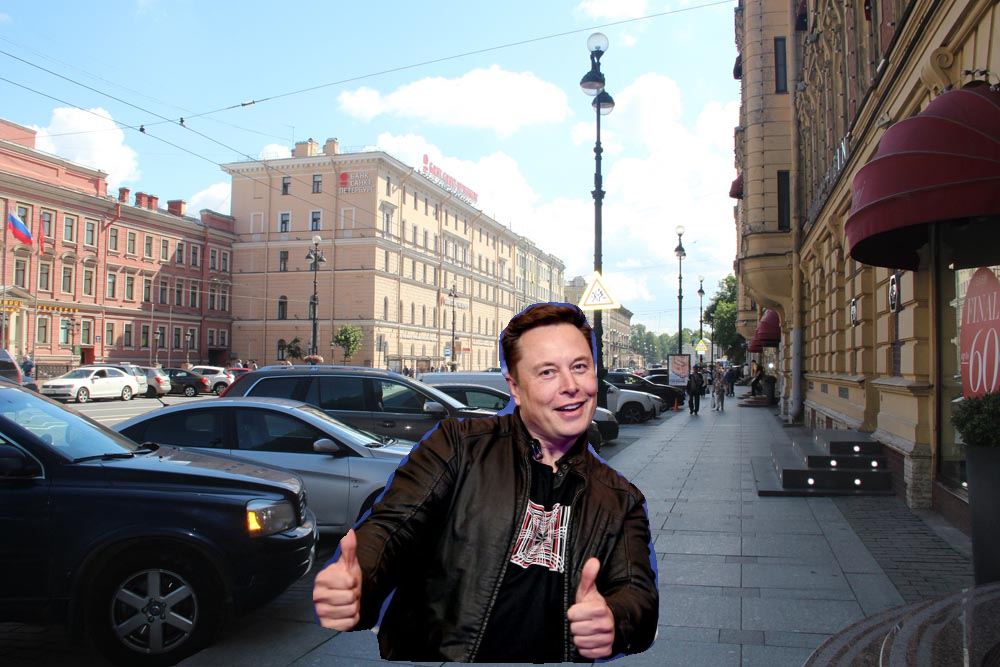

In [ ]:
final_img3 = elon_in_spb(img3, background, mask3, 290, 250)
cv2_imshow(final_img3)

---